# Neural style transfer

## Introduction

Style transfer consists in generating an image
with the same "content" as a base image, but with the
"style" of a different picture (typically artistic).
This is achieved through the optimization of a loss function
that has 3 components: "style loss", "content loss",
and "total variation loss":

- The total variation loss imposes local spatial continuity between
the pixels of the combination image, giving it visual coherence.
- The style loss is where the deep learning keeps in --that one is defined
using a deep convolutional neural network. Precisely, it consists in a sum of
L2 distances between the Gram matrices of the representations of
the base image and the style reference image, extracted from
different layers of a convnet (trained on ImageNet). The general idea
is to capture color/texture information at different spatial
scales (fairly large scales --defined by the depth of the layer considered).
- The content loss is a L2 distance between the features of the base
image (extracted from a deep layer) and the features of the combination image,
keeping the generated image close enough to the original one.

**Reference:** [A Neural Algorithm of Artistic Style](
  http://arxiv.org/abs/1508.06576)


## Setup


In [1]:
import numpy as np
from PIL import Image

base_image_path = './datasets/paris.jpg'
style_reference_image_path = './datasets/starry_night.jpg'

## Let's take a look at our base (content) image and our style reference image


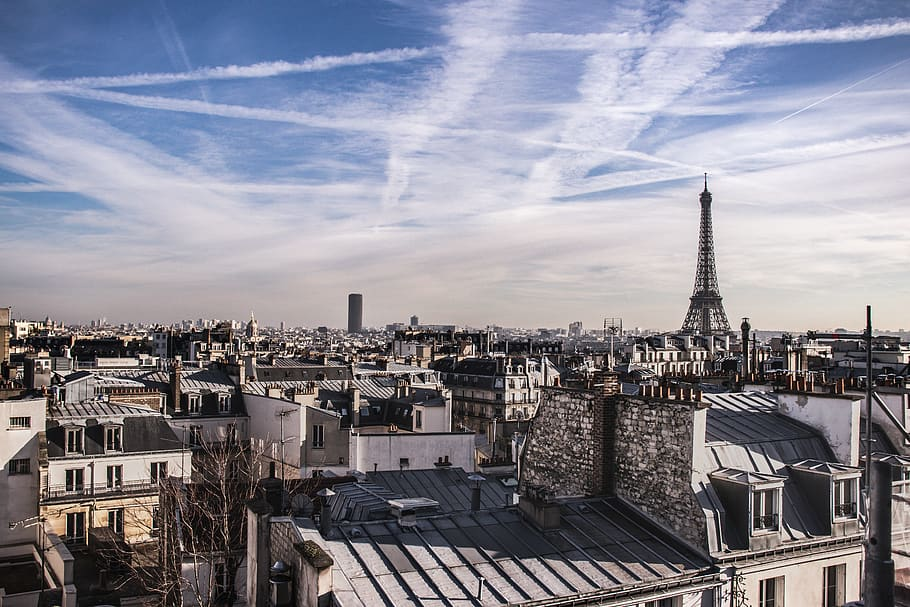

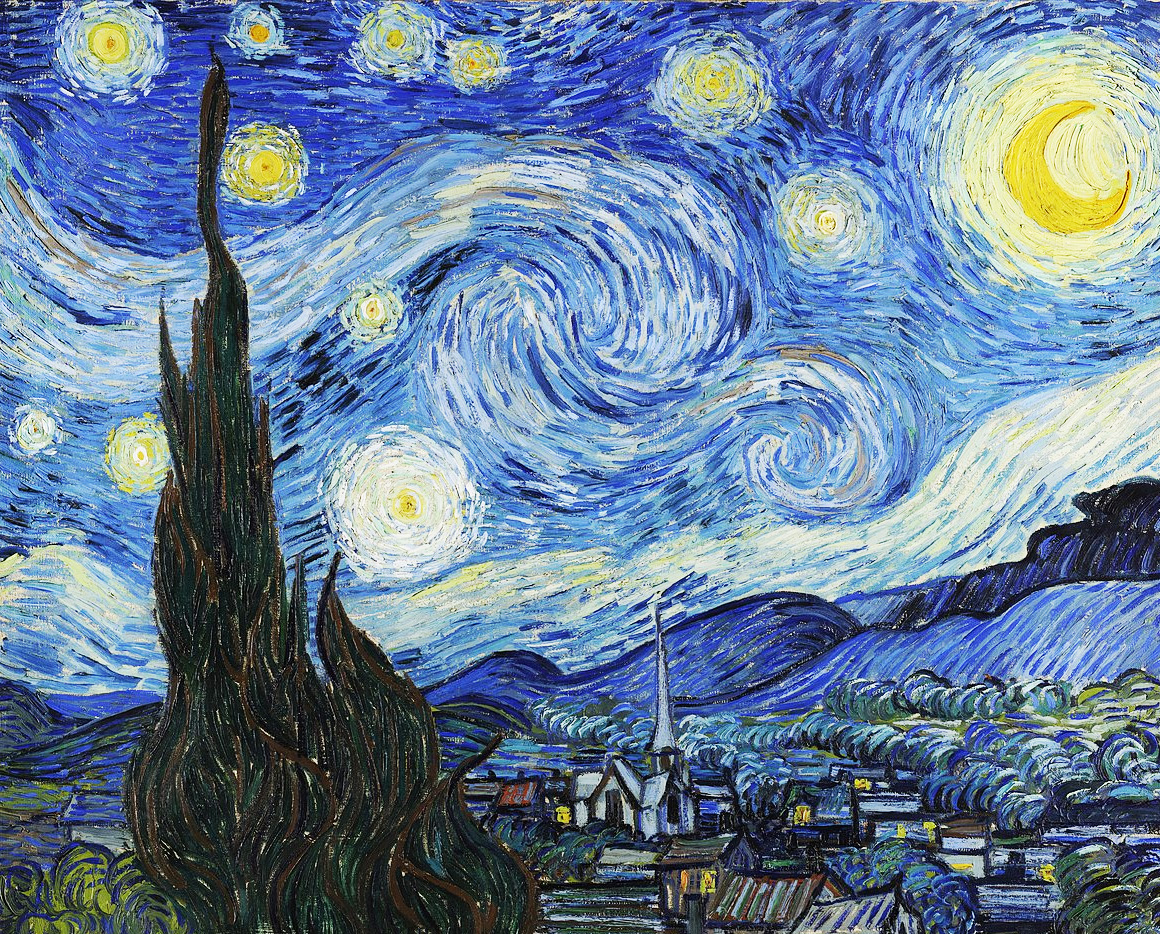

In [2]:
from IPython.display import Image as imshow
from IPython.display import display
display(imshow(base_image_path))
display(imshow(style_reference_image_path))

## Image preprocessing / deprocessing utilities


* PyTorch 참고 링크 : https://github.com/suubkiim/Pytorch-tutorial/blob/master/tutorials/03-advanced/neural_style_transfer/main.py

In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision import models

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def preprocess_image(image_path, shape=None):
    """Load an image and convert it to a torch tensor."""
    
    # VGGNet was trained on ImageNet where images are normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
    # We use the same normalization statistics here.
    image = Image.open(image_path) # (400, 599) = (width, height)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(shape),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                             std=(0.229, 0.224, 0.225))])
    
    image = transform(image).unsqueeze(0) # dim=0으로 차원 추가 (1(batch),3(ch), 400(height), 599(width))
         
    return image.to(device)

## Compute the style transfer loss

First, we need to define 4 utility functions:

- `gram_matrix` (used to compute the style loss)
- The `style_loss` function, which keeps the generated image close to the local textures
of the style reference image
- The `content_loss` function, which keeps the high-level representation of the
generated image close to that of the base image
- The `total_variation_loss` function, a regularization loss which keeps the generated
image locally-coherent


<center>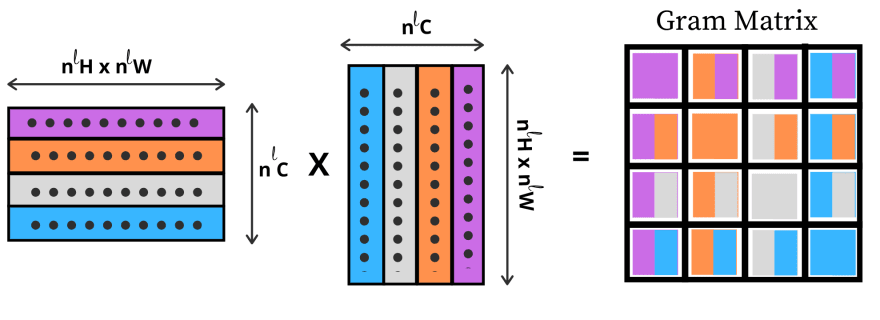

* Gram matrix란 Flatten 한 Feature map들 간에 계산된 Covariance matrix이다.

In [4]:
# The gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):
    # x : [64, 400, 599]
    features = torch.reshape(x, (x.shape[0], -1)) # (64, 239600(=400*599))
    gram = torch.matmul(features, features.T) # [64,64]
    return gram

# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

# The general idea is to capture color/texture information at different spatial scales
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return torch.mean((S - C)**2) / (channels * size) # style과 transfer 이미지 간 차이가 초기에 클 수밖에 없으므로

# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image

# style loss는 점점 감소해야하고 content loss는 점점 증가
# Keeping the generated image close enough to the original one
def content_loss(base, combination):
    return torch.mean((combination - base)**2)


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x): # transfoer 된 이미지의 locally coherent 함 유지하기 위한 제약
    # torch.Size([1, 3, 400, 599])
    a = torch.square(
        x[:, :,  : img_nrows - 1, : img_ncols - 1] - x[:, :,  1:, : img_ncols - 1]
    )
    b = torch.square(
        x[:, :, : img_nrows - 1, : img_ncols - 1] - x[:, :, : img_nrows - 1, 1:]
    )

    return torch.sum(torch.pow(a + b, 1.25))

### Next, let's create a feature extraction model that retrieves the intermediate activations of VGG19 (as a dict, by name).


In [5]:
class VGGNet(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        super(VGGNet, self).__init__()
        self.select = ['0', '5', '10', '19', '28', '30'] # vgg net layer number
        self.vgg = models.vgg19(pretrained=True).features # torchvision.models
        
    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

* https://kyounju.tistory.com/3

<center>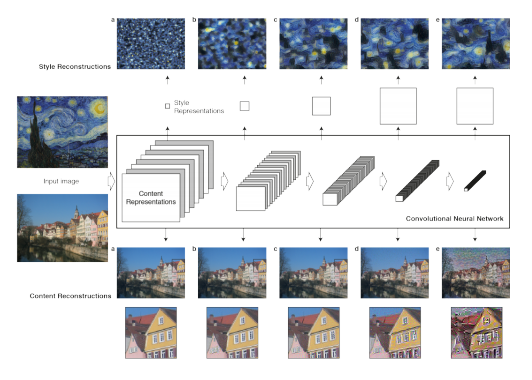


* Style Represenation에서는 원래 그림의 전체적인 배열(global arrangement)은 점차 사라지고 반복되는(Texturised) 색감과 구조를 고유한 특성(Feature)을 추출한다는 것을 확인하였다.
* 사진과 그림을 합칠 때 그림의 전체적인 배열(global arrangement)는 버려지고 반복되는 Featrue(or Texture)만 남게 된다. 반면에 Content에서는 Object를 확인할 수 있는 Feature들이 남기 때문에 Content의 전체적인 틀(global arrangement)에 그림의 Texture를 입힌 모습으로 생산될 수 있는 것이다

<center>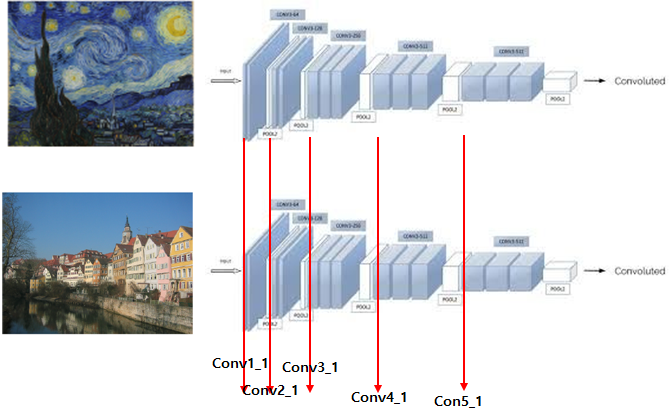

<center>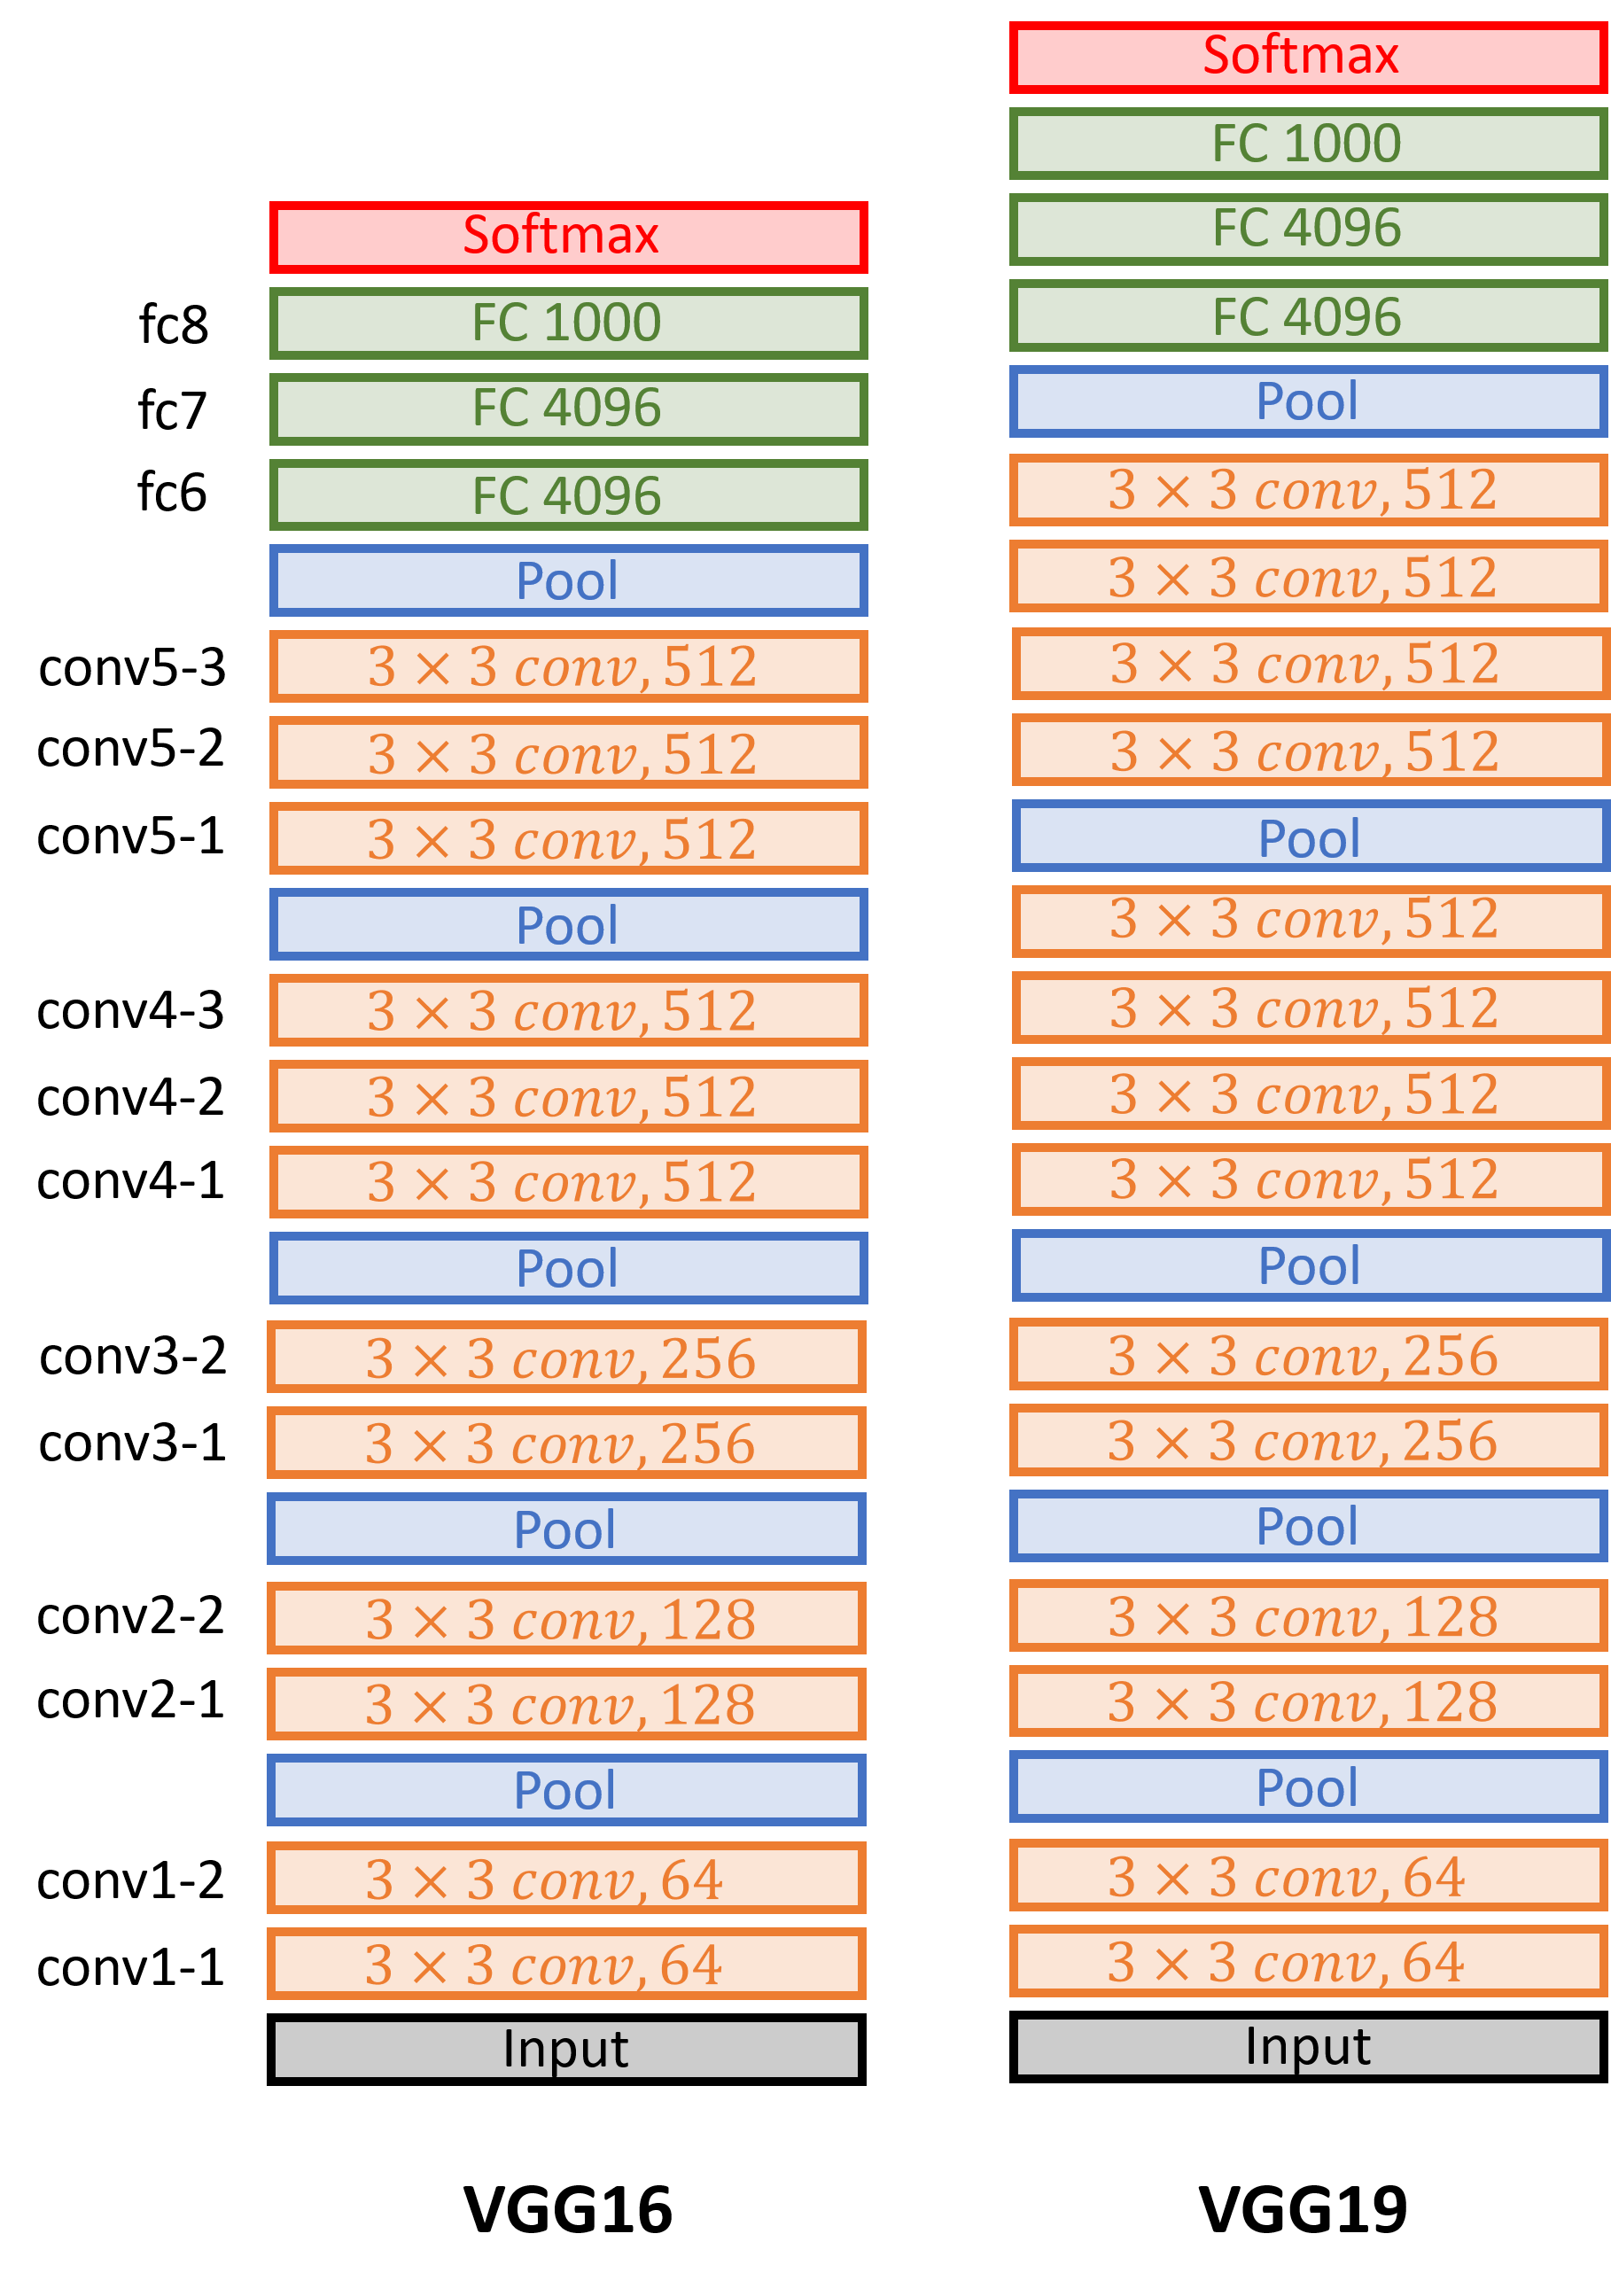


In [6]:
VGGNet()

VGGNet(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddin

### Finally, here's the code that computes the style transfer loss.


In [7]:
# ['0', '5', '10', '19', '28', '30'] 

# Dict of layers to use for the style loss.
style_layer_names = {
    "block1_conv1":0,
    "block2_conv1":1,
    "block3_conv1":2,
    "block4_conv1":3,
    "block5_conv1":4,
}

# The layer to use for the content loss.
content_layer_name = {"block5_conv2":5}

In [16]:
# Weights of the different loss components
total_variation_weight = 1 # 1e-6
style_weight = 1000        # 1e-6
content_weight = 1         # 2.5e-8

def compute_loss(model, combination_image, base_image, style_reference_image):

    # Extract multiple(5+1) conv feature vectors
    combination_image_features = model(combination_image)
    base_image_features = model(base_image)
    style_reference_image_features = model(style_reference_image)
        
    # Add content loss
    # base이미지와 transfer 이미지 간의 loss는 block5의 conv2 layer feature 사용
    base_image_features = base_image_features[content_layer_name['block5_conv2']]
    combination_features = combination_image_features[content_layer_name['block5_conv2']]
    loss = content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    # transfer 이미지와 style 이미지 간의 loss는 위에서 정의한 5개의 layer feature의 평균 사용
    for layer_name in style_layer_names.values():
        style_reference_features = style_reference_image_features[layer_name][0] # except block5_conv2
        combination_features = combination_image_features[layer_name][0] # except block5_conv2
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl
    
    # Add total variation loss
    # transfer 이미지의 locally coherency 유지
    loss += total_variation_weight * total_variation_loss(combination_image)
    
    return loss


## The training loop

Repeatedly run vanilla gradient descent steps to minimize the loss, and save the
resulting image every 100 iterations.

We decay the learning rate by 0.96 every 100 steps.


___
**학습시 중요하게 고려해야할 사항**
* Image input scaling/preprocessing 방법에 따라서 L2 loss 값이 달라짐
    * style_weight 조정
        - style loss와 content loss의 각 가중치 설정 중요 (+ loss 정의)
        - cf. keras : style_weight : 1e-6 (이미지 픽셀 값 자체가 크게 들어감. e.g. 20-30)
        - PyTorch : 100, 1000 같은 가중치로 학습 -> 이것도 민감하기 때문에 잘 설정할 필요 (Normalized Image 사용)

* learning rate

In [9]:
# Dimensions of the generated picture.
width, height = Image.open(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height) # image

class Config:
    def __init__(self):
        self.base_image_path = './datasets/paris.jpg'
        self.style_reference_image_path = './datasets/starry_night.jpg'
        self.img_nrows = img_nrows 
        self.img_ncols = img_ncols 
        self.lr = 0.0003
        self.total_step = 4000
        self.log_step = 50
        self.sample_step = 200
        self.decay_step_size = 100
        self.decay_rate = 0.96
        
config = Config()

In [17]:
# Load content and style images
# Make the style image same size as the base image

base_image = preprocess_image(config.base_image_path, shape=[config.img_nrows, config.img_ncols])
style_reference_image = preprocess_image(config.style_reference_image_path, shape=[config.img_nrows, config.img_ncols])

# Initialize a target image with the content image
combination_image = base_image.clone().requires_grad_(True)

optimizer = torch.optim.SGD([combination_image], lr=config.lr, weight_decay=0.96)

vgg = VGGNet().to(device).eval()

for step in range(config.total_step):
    
    # Compute total loss, backprop and optimize
    loss = compute_loss(vgg, combination_image, base_image, style_reference_image)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step+1) % config.log_step == 0:
        print ('Step [{}/{}], Loss: {:.4f}' 
               .format(step+1, config.total_step, loss.item()))

    if (step+1) % config.sample_step == 0:
        # Save the generated image
        denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
        transferred_img = combination_image.clone().squeeze()
        transferred_img = denorm(transferred_img).clamp_(0, 1)
        torchvision.utils.save_image(transferred_img, 'results/output-{}.png'.format(step+1))

Step [50/4000], Loss: 1221014.8750
Step [100/4000], Loss: 883195.3750
Step [150/4000], Loss: 713023.0000
Step [200/4000], Loss: 611576.8750
Step [250/4000], Loss: 547468.0000
Step [300/4000], Loss: 505244.2500
Step [350/4000], Loss: 476270.4375
Step [400/4000], Loss: 455622.1875
Step [450/4000], Loss: 440337.6875
Step [500/4000], Loss: 428659.9375
Step [550/4000], Loss: 419499.8125
Step [600/4000], Loss: 412125.9688
Step [650/4000], Loss: 406084.5625
Step [700/4000], Loss: 401056.4375
Step [750/4000], Loss: 396814.0625
Step [800/4000], Loss: 393197.4688
Step [850/4000], Loss: 390081.0625
Step [900/4000], Loss: 387370.8750
Step [950/4000], Loss: 384993.5312
Step [1000/4000], Loss: 382893.7812
Step [1050/4000], Loss: 381030.9688
Step [1100/4000], Loss: 379374.5000
Step [1150/4000], Loss: 377898.2812
Step [1200/4000], Loss: 376574.0000
Step [1250/4000], Loss: 375377.0000
Step [1300/4000], Loss: 374294.3438
Step [1350/4000], Loss: 373315.8750
Step [1400/4000], Loss: 372428.8750
Step [1450/

In [11]:
# inv_normalize = transforms.Normalize(
#     mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
#     std=[1/0.229, 1/0.224, 1/0.255]
# )

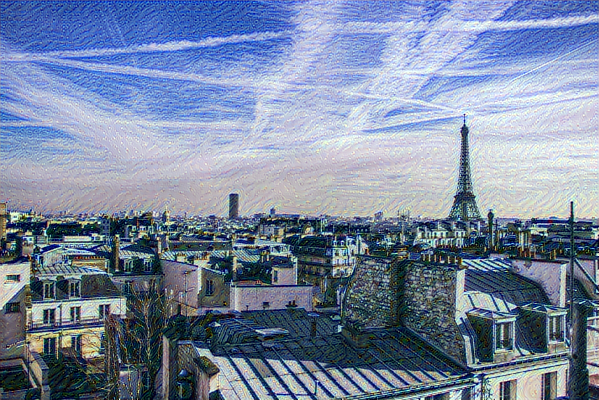

In [32]:
display(imshow('results_weight1000/output-200.png'))

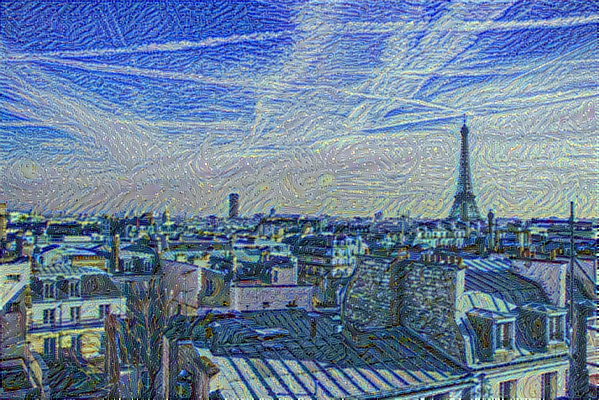

In [31]:
display(imshow('results_weight1000/output-2000.png'))

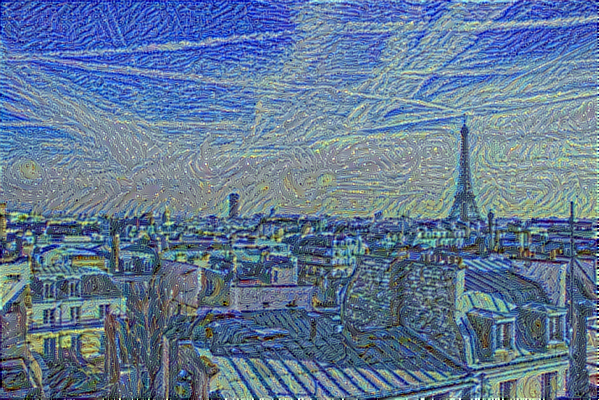

In [30]:
display(imshow('results_weight1000/output-4000.png'))